In [1]:
from gensim.models import Word2Vec
from sklearn.svm import SVC
from tqdm import tqdm  # tqdm 用于显示进度条
import time
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

## 读取数据

In [2]:
# 文件路径
file_path_neg = 'negative_trainingSet'
file_path_pos = 'positive_trainingSet'

In [3]:

# 逐行读取负例文件内容，使用GBK编码
with open(file_path_neg, 'r', encoding='gbk') as f:
    negative_titles = f.readlines()

# 逐行读取正例文件内容，使用GBK编码
with open(file_path_pos, 'r', encoding='gbk') as f:
    positive_titles = f.readlines()

# 去除多余的换行符，并存储为DataFrame
negative_data = pd.DataFrame({'title': [line.strip() for line in negative_titles]})
positive_data = pd.DataFrame({'title': [line.strip() for line in positive_titles]})

In [4]:
# 添加标签（负类为0，正类为1）
negative_data['label'] = 0
positive_data['label'] = 1

# 合并数据并打乱顺序
train_data = pd.concat([negative_data, positive_data], ignore_index=True)
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [5]:
# 查看数据分布和前几行
print(train_data['label'].value_counts())
print(train_data.head())

label
1    118079
0    118079
Name: count, dtype: int64
                                               title  label
0                    On recognizable timed languages      1
1                 Improving System Understanding via      0
2    Design patterns for legal ontology construction      0
3  Advance Access published on June 20, 2006 doi:...      0
4               Processing MPI Datatypes outside MPI      1


In [6]:
# 读取测试集
test_file_path = 'testSet-1000.xlsx'
test_data = pd.read_excel(test_file_path)

In [7]:
# 查看文件的前几行，确认数据结构
print(test_data.head())

                    id                             title given by machine  \
0  10.1.1.211.3354.txt  An Experimental Evaluation of the HP VClass an...   
1   10.1.1.64.7282.txt       Running Title: Entropy-enthalpy compensation   
2  10.1.1.125.7401.txt  CIFOR REPORTS ON DECENTRALIZATION AND FORESTS ...   
3   10.1.1.32.6721.txt  Optimal Feedback Control for Route Tracking Wi...   
4  10.1.1.118.5296.txt  Call for Papers.......................41 Fragm...   

  label                                     original title  
0     N  An experimental evaluation of the HP V-class a...  
1     N  Entropy-enthalpy compensation: conformational ...  
2     N  The dynamics of decentralization in the forest...  
3     Y                                                NaN  
4     N                         The Social Life of Routers  


## 处理测试数据

In [8]:
# 提取机器提取的标题和标签（'Y' 或 'N'）
test_data_clean = test_data[['title given by machine', 'label']].copy()

# 将 'Y/N' 标签转化为 1（正确）和 0（错误）
# 对数据创建新的列并显式赋
test_data_clean['label'] = test_data_clean['label'].apply(lambda x: 1 if x == 'Y' else 0)

In [9]:
# 查看处理后的数据
print(test_data_clean.head())

                              title given by machine  label
0  An Experimental Evaluation of the HP VClass an...      0
1       Running Title: Entropy-enthalpy compensation      0
2  CIFOR REPORTS ON DECENTRALIZATION AND FORESTS ...      0
3  Optimal Feedback Control for Route Tracking Wi...      1
4  Call for Papers.......................41 Fragm...      0


In [10]:
# 清理数据，确保所有标题是字符串类型
test_data_clean['title given by machine'] = test_data_clean['title given by machine'].fillna('').astype(str)


In [11]:
# # 初始化TfidfVectorizer，去除停用词并限制特征数量
# vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# # 对训练数据进行训练并转化为特征
# X_train = vectorizer.fit_transform(train_data['title'])


# # 对测试数据进行特征提取
# X_test = vectorizer.transform(test_data_clean['title given by machine'])
y_test = test_data_clean['label']
y_train = train_data['label']

## 构建Word2Vec模型

In [12]:
# 构建Word2Vec模型
sentences = [title.split() for title in train_data['title']]
word2vec_model = Word2Vec(sentences, vector_size=500, window=6, min_count=1, workers=4)

In [13]:
# 获取每个标题的词向量表示
def get_word2vec_representation(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

In [14]:
X_train_word2vec = [get_word2vec_representation(title) for title in train_data['title']]

In [15]:
X_test_word2vec = [get_word2vec_representation(title) for title in test_data_clean['title given by machine']]

# 训练SVM模型

### linearSVM

In [44]:
svm_model_word2vec = LinearSVC(max_iter=10000, tol=1e-5, C=1,random_state=42)
svm_model_word2vec.fit(X_train_word2vec, y_train)

LinearSVC(C=1, max_iter=10000, random_state=42, tol=1e-05)

In [45]:
y_pred_word2vec_svm = svm_model_word2vec.predict(X_test_word2vec)

In [46]:
print("SVM Classifier Report:")
print(classification_report(test_data_clean['label'], y_pred_word2vec_svm))

SVM Classifier Report:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       432
           1       0.77      0.68      0.72       568

    accuracy                           0.70      1000
   macro avg       0.70      0.71      0.70      1000
weighted avg       0.71      0.70      0.70      1000



### svm_rbf

In [16]:
svm_model_word2vec_rbf = SVC(kernel='rbf', C=1.0, tol=1e-6, random_state=42)

In [17]:
svm_model_word2vec_rbf.fit(X_train_word2vec, y_train)

SVC(random_state=42, tol=1e-06)

In [18]:
y_pred_word2vec_svm_rbf = svm_model_word2vec_rbf.predict(X_test_word2vec)

In [19]:
# 输出分类报告
print("Classification Report (Word2Vec + SVM with RBF kernel):")
print(classification_report(y_test, y_pred_word2vec_svm_rbf))

Classification Report (Word2Vec + SVM with RBF kernel):
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       432
           1       0.79      0.84      0.82       568

    accuracy                           0.79      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.79      0.79      0.78      1000



In [142]:
# 数据分批训练（假设 X_train_word2vec 是一个 numpy 数组）
batch_size = 11000
num_batches = len(X_train_word2vec) // batch_size

In [143]:
# 创建一个进度条
progress_bar = tqdm(total=num_batches, desc="Training Progress")

Training Progress:   0%|                                                               | 0/21 [00:00<?, ?it/s]

In [144]:
# 模拟逐批训练（示例，SVM 本身不支持分批训练，但可以换为增量学习模型）
for i in range(num_batches):
    batch_X = X_train_word2vec[i * batch_size : (i + 1) * batch_size]
    batch_y = y_train[i * batch_size : (i + 1) * batch_size]
    svm_model_word2vec_rbf.fit(batch_X, batch_y)  
    progress_bar.update(1)

progress_bar.close()

/home/cci/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/cci/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/cci/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/cci/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/cci/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminate

### 参数优化

In [30]:
# 定义参数网格
param_grid = {
    'C': [0.1, 1, 10, 100],  # 正则化参数
    'tol': [1e-4, 1e-5, 1e-6],  # 停止优化的容忍度
    'max_iter': [1000, 5000, 10000]  # 最大迭代次数
}

In [31]:
# 初始化模型
svm_model = LinearSVC(random_state=42)

In [32]:
# 使用 GridSearchCV 搜索最优参数
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train_word2vec, train_data['label'])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ...................C=0.1, max_iter=1000, tol=0.0001; total time=  23.4s
[CV] END ...................C=0.1, max_iter=1000, tol=0.0001; total time=  19.7s
[CV] END ...................C=0.1, max_iter=1000, tol=0.0001; total time=  23.8s
[CV] END ...................C=0.1, max_iter=1000, tol=0.0001; total time=  19.8s
[CV] END ...................C=0.1, max_iter=1000, tol=0.0001; total time=  20.3s
[CV] END ....................C=0.1, max_iter=1000, tol=1e-05; total time=  30.0s
[CV] END ....................C=0.1, max_iter=1000, tol=1e-05; total time=  26.6s
[CV] END ....................C=0.1, max_iter=1000, tol=1e-05; total time=  30.7s
[CV] END ....................C=0.1, max_iter=1000, tol=1e-05; total time=  26.7s
[CV] END ....................C=0.1, max_iter=1000, tol=1e-05; total time=  27.5s
[CV] END ....................C=0.1, max_iter=1000, tol=1e-06; total time=  37.3s
[CV] END ....................C=0.1, max_iter=10

GridSearchCV(cv=5, estimator=LinearSVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100],
                         'max_iter': [1000, 5000, 10000],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring='accuracy', verbose=2)

In [33]:
# 输出最优参数
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 1, 'max_iter': 1000, 'tol': 1e-05}


In [ ]:
best_model = grid_search.best_estimator_

In [56]:
y_best_word2vec_svm = best_model.predict(X_test_word2vec)

In [57]:
print("SVM Classifier Report:")
print(classification_report(test_data_clean['label'], y_pred_word2vec_svm))

SVM Classifier Report:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       432
           1       0.77      0.68      0.72       568

    accuracy                           0.70      1000
   macro avg       0.70      0.71      0.70      1000
weighted avg       0.71      0.70      0.70      1000



In [ ]:
# svm_model_word2vec_rbf.fit(X_train_word2vec, y_train)

### 结果可视化

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

#### 初始化 t-SNE，降到2维

In [23]:
decision_values = svm_model_word2vec_rbf.decision_function(X_test_word2vec)

In [25]:
decision_values_2d = decision_values.reshape(-1, 1)

In [30]:
X_test_combined = np.hstack((decision_values_2d, X_test_word2vec))

In [42]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1)
X_test_2d = tsne.fit_transform(np.array(X_test_word2vec))

#### 对高维特征降维

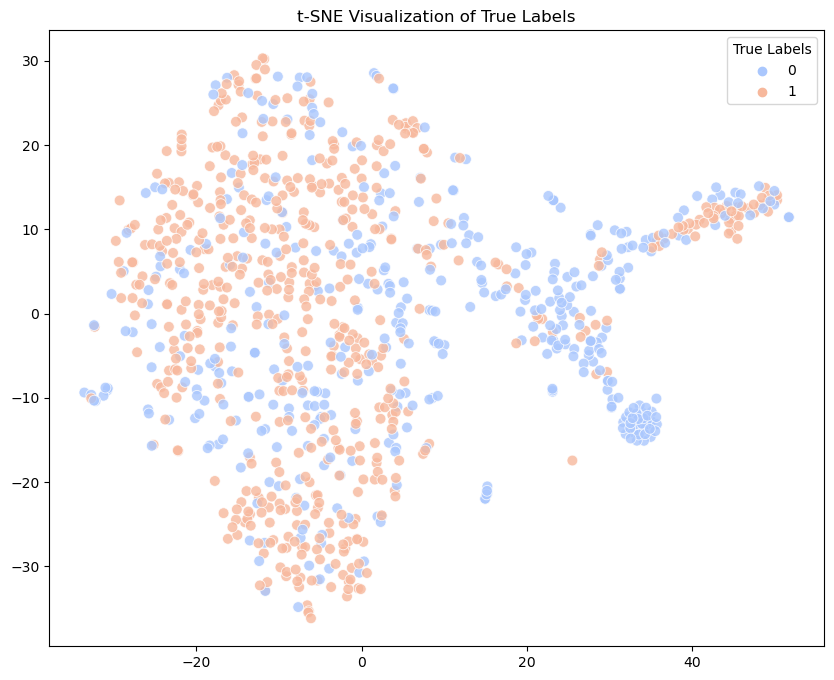

In [43]:
# 可视化真实标签的分布
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=X_test_2d[:, 0], y=X_test_2d[:, 1], hue=y_test, palette="coolwarm", s=60,
    legend="full", alpha=0.8
)
plt.title("t-SNE Visualization of True Labels")
plt.legend(title="True Labels")
plt.show()


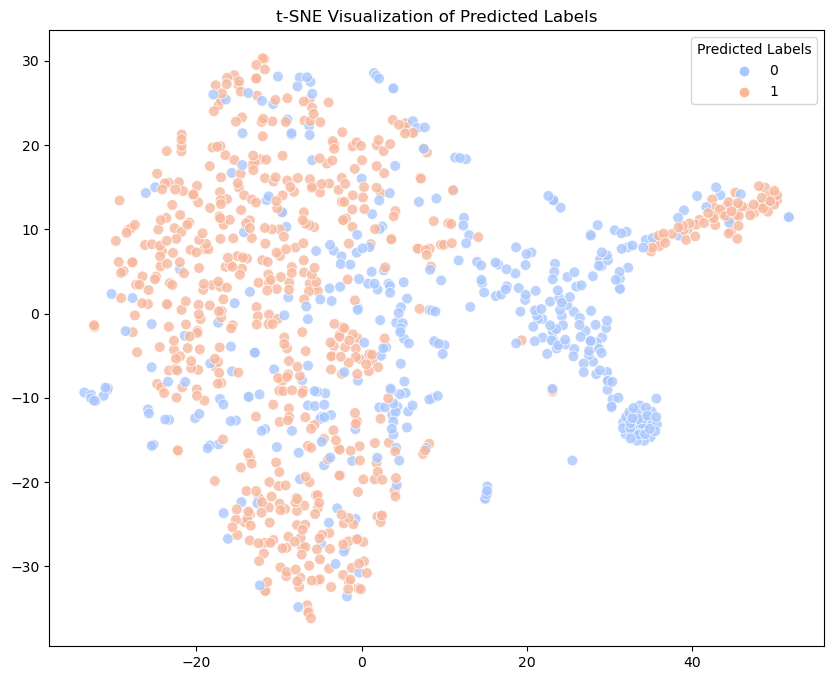

In [44]:
# 可视化预测标签的分布
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_test_2d[:, 0], y=X_test_2d[:, 1], hue=y_pred_word2vec_svm_rbf, palette="coolwarm", s=60,
    legend="full", alpha=0.8
)
plt.title("t-SNE Visualization of Predicted Labels")
plt.legend(title="Predicted Labels")
plt.show()